In [23]:
# !pip install numpy==1.26.4
import pickle
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%cd ~/ieai-miniproject-context-mixing/

/gpfs/home3/scur2348/ieai-miniproject-context-mixing


/home/scur2348/ieai-miniproject-context-mixing/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/scur2348/ieai-miniproject-context-mixing/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
MODEL_TYPE = 'encoder'
MODEL = 'wav2vec2-large-xlsr-53-french'

In [3]:
ATTN_SCORES_PATH = f'directory/scores/common_voice/test/all/{MODEL}/attentions/'
VZ_SCORES_PATH = f'directory/scores/common_voice/test/all/{MODEL}/value_zeroing/'
PREDICTIONS_PATH = f'directory/predictions/common_voice/test/{MODEL}/'
DATASET_PATH = 'directory/datasets/common_voice/test/all/'
# 'directory\scores\common_voice\test\whisper-small\whisper-small\cross_valueZeroing-cosine_mean.pkl'

In [4]:
with open(ATTN_SCORES_PATH + f'{MODEL_TYPE}_attention_mean.pkl', 'rb') as f:
    attn_scores = [a.mean(axis=1) for a in pickle.load(f)]
with open(ATTN_SCORES_PATH + f'{MODEL_TYPE}_summedNorms_mean.pkl', 'rb') as f:
    an_scores = pickle.load(f)
with open(VZ_SCORES_PATH + f'{MODEL_TYPE}_valueZeroing-cosine_mean.pkl', 'rb') as f:
    vz_scores = pickle.load(f)

with open(ATTN_SCORES_PATH + f'{MODEL_TYPE}_attention_mean_random.pkl', 'rb') as f:
    attn_scores_rand = [a.mean(axis=1) for a in pickle.load(f)]
with open(ATTN_SCORES_PATH + f'{MODEL_TYPE}_summedNorms_mean_random.pkl', 'rb') as f:
    an_scores_rand = pickle.load(f)
# with open(VZ_SCORES_PATH + f'{MODEL_TYPE}_valueZeroing-cosine_mean_random.pkl', 'rb') as f:
#     vz_scores_rand = pickle.load(f)

scores_correct = [attn_scores, an_scores, vz_scores]
scores_rand = [attn_scores_rand, an_scores_rand, 
            #    vz_scores_rand
               ]

In [5]:
print(attn_scores[0].shape)
print(an_scores[0].shape)
print(vz_scores[0].shape)

(24, 12, 12)
(24, 12, 12)
(24, 12, 12)


In [6]:
dataset = load_dataset("arrow", data_files={'test': DATASET_PATH + 'data-0000*-of-00004.arrow'})['test']

In [7]:
def get_layer_scores(dataset, scores, n, n_scores, n_layers):
    scores_filtered = np.zeros((n, n_scores, n_layers))

    for i in range(n):
        i_cue = dataset['cue_indices'][i]['enc']
        i_target = dataset['target_indices'][i]['enc']

        cue_slice = slice(i_cue[0], i_cue[-1] + 1)
        target_slice = slice(i_target[0], i_target[-1] + 1)
        for j, score in enumerate(scores):
            scores_filtered[i, j] = score[i][:, target_slice, cue_slice].mean(axis=(1, 2))

    return scores_filtered.mean(axis=0).T[::-1]

In [8]:
n = len(attn_scores)
n_scores = 3
n_layers = attn_scores[0].shape[0]

scores_filtered = [
    get_layer_scores(dataset, scores_correct, n, n_scores, n_layers),
    get_layer_scores(dataset, scores_correct, n, n_scores, n_layers),
    get_layer_scores(dataset, scores_rand, n, n_scores, n_layers)
]

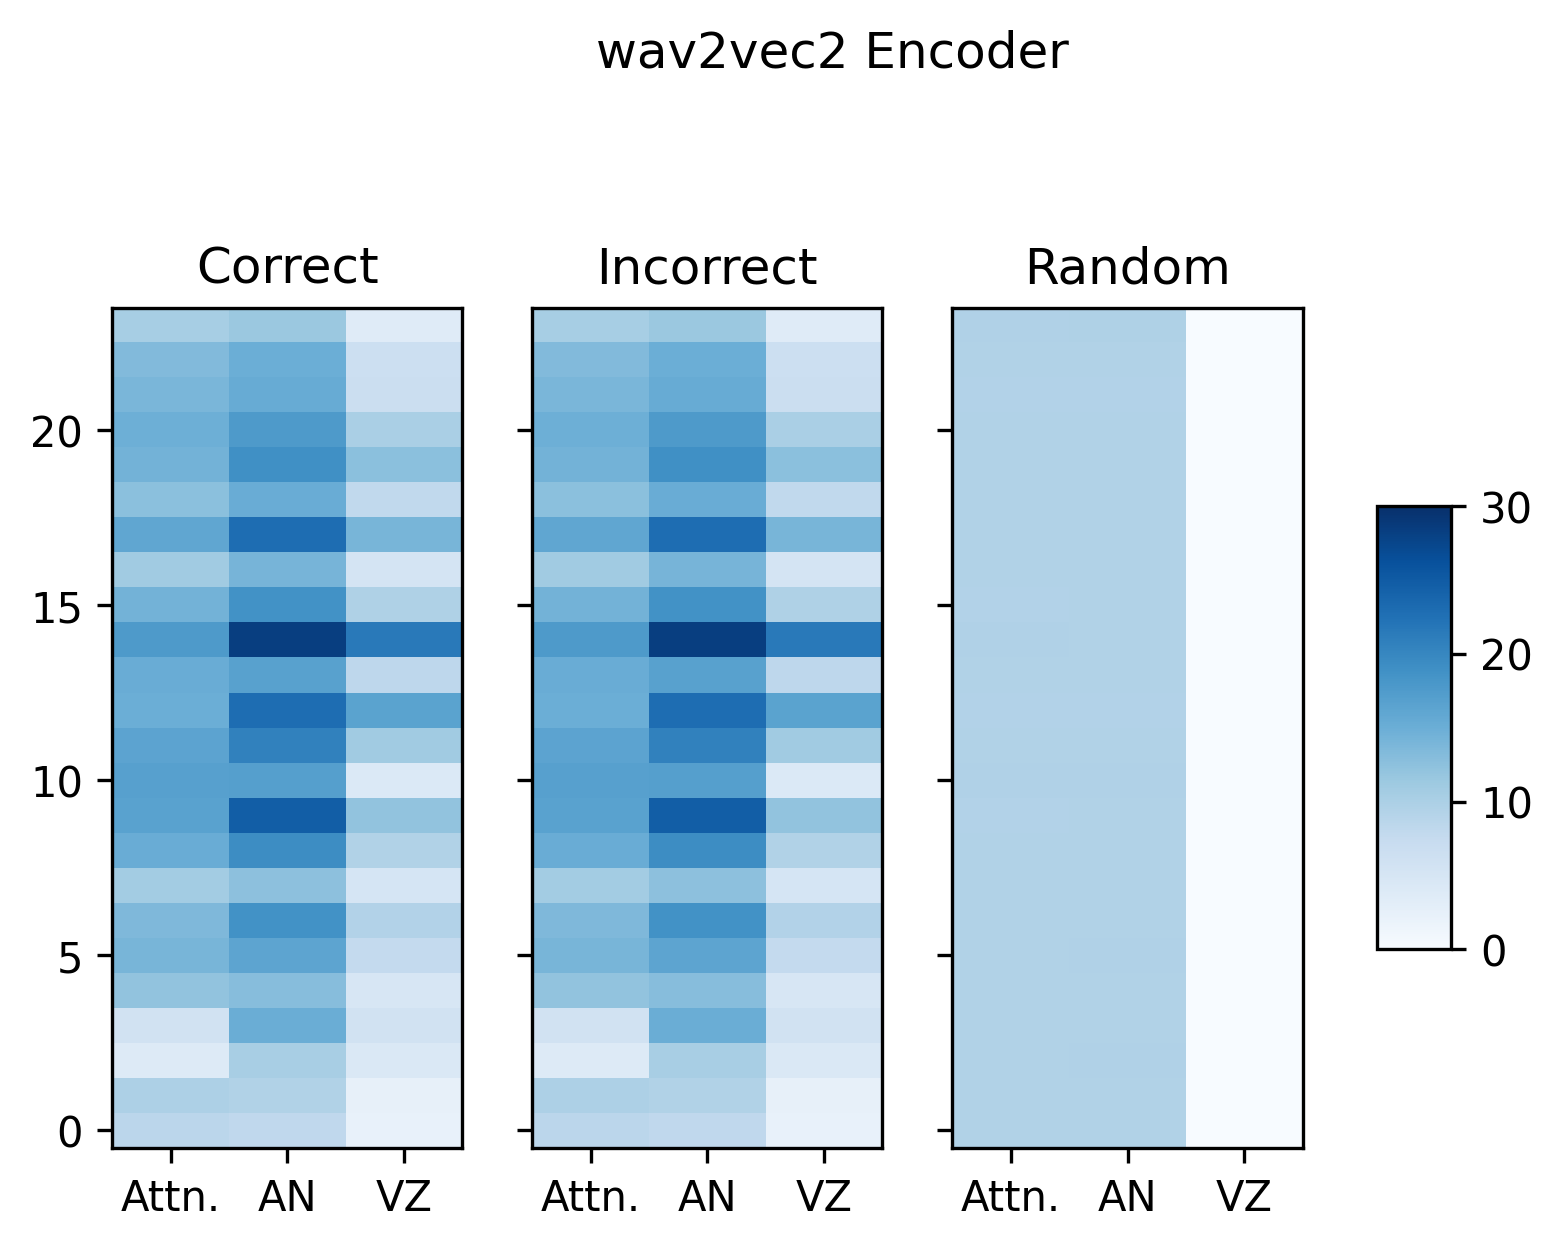

In [63]:
labels = ['Attn.', 'AN', 'VZ']
titles = ['Correct', 'Incorrect', 'Random']

fig, axs = plt.subplots(1, 3, sharey=True, dpi=300)

for i in range(len(scores_filtered)):
    im = axs[i].imshow(
        scores_filtered[i] * 100, 
        cmap='Blues',
        vmin=0,
        vmax=30,
        aspect=0.3,
    )
    axs[i].set_xticks(range(len(labels)), labels)
    axs[i].set_title(titles[i])
    axs[i].invert_yaxis()

fig.suptitle('wav2vec2 Encoder')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4, aspect=6)
# plt.tight_layout()
plt.show()